# Dataset Overview & Clean-up

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import seaborn as sns
import time
import warnings

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import FitFailedWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [97]:
df = pd.read_csv('../data/card_transdata.csv')

### Dataset Overview

In [98]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [99]:
df.loc[df['fraud'] == 1]

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
13,2.131956,56.372401,6.358667,1.0,0.0,0.0,1.0,1.0
24,3.803057,67.241081,1.872950,1.0,0.0,0.0,1.0,1.0
29,15.694986,175.989182,0.855623,1.0,0.0,0.0,1.0,1.0
35,26.711462,1.552008,4.603601,1.0,1.0,0.0,1.0,1.0
36,10.664474,1.565769,4.886521,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
999908,45.296658,0.882736,8.856861,1.0,0.0,0.0,1.0,1.0
999916,167.139756,0.282253,0.308468,1.0,0.0,0.0,1.0,1.0
999919,124.640118,0.004416,0.434885,1.0,0.0,0.0,1.0,1.0
999939,51.412900,3.429330,29.914254,1.0,0.0,0.0,1.0,1.0


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [101]:
df.shape

(1000000, 8)

In [102]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object

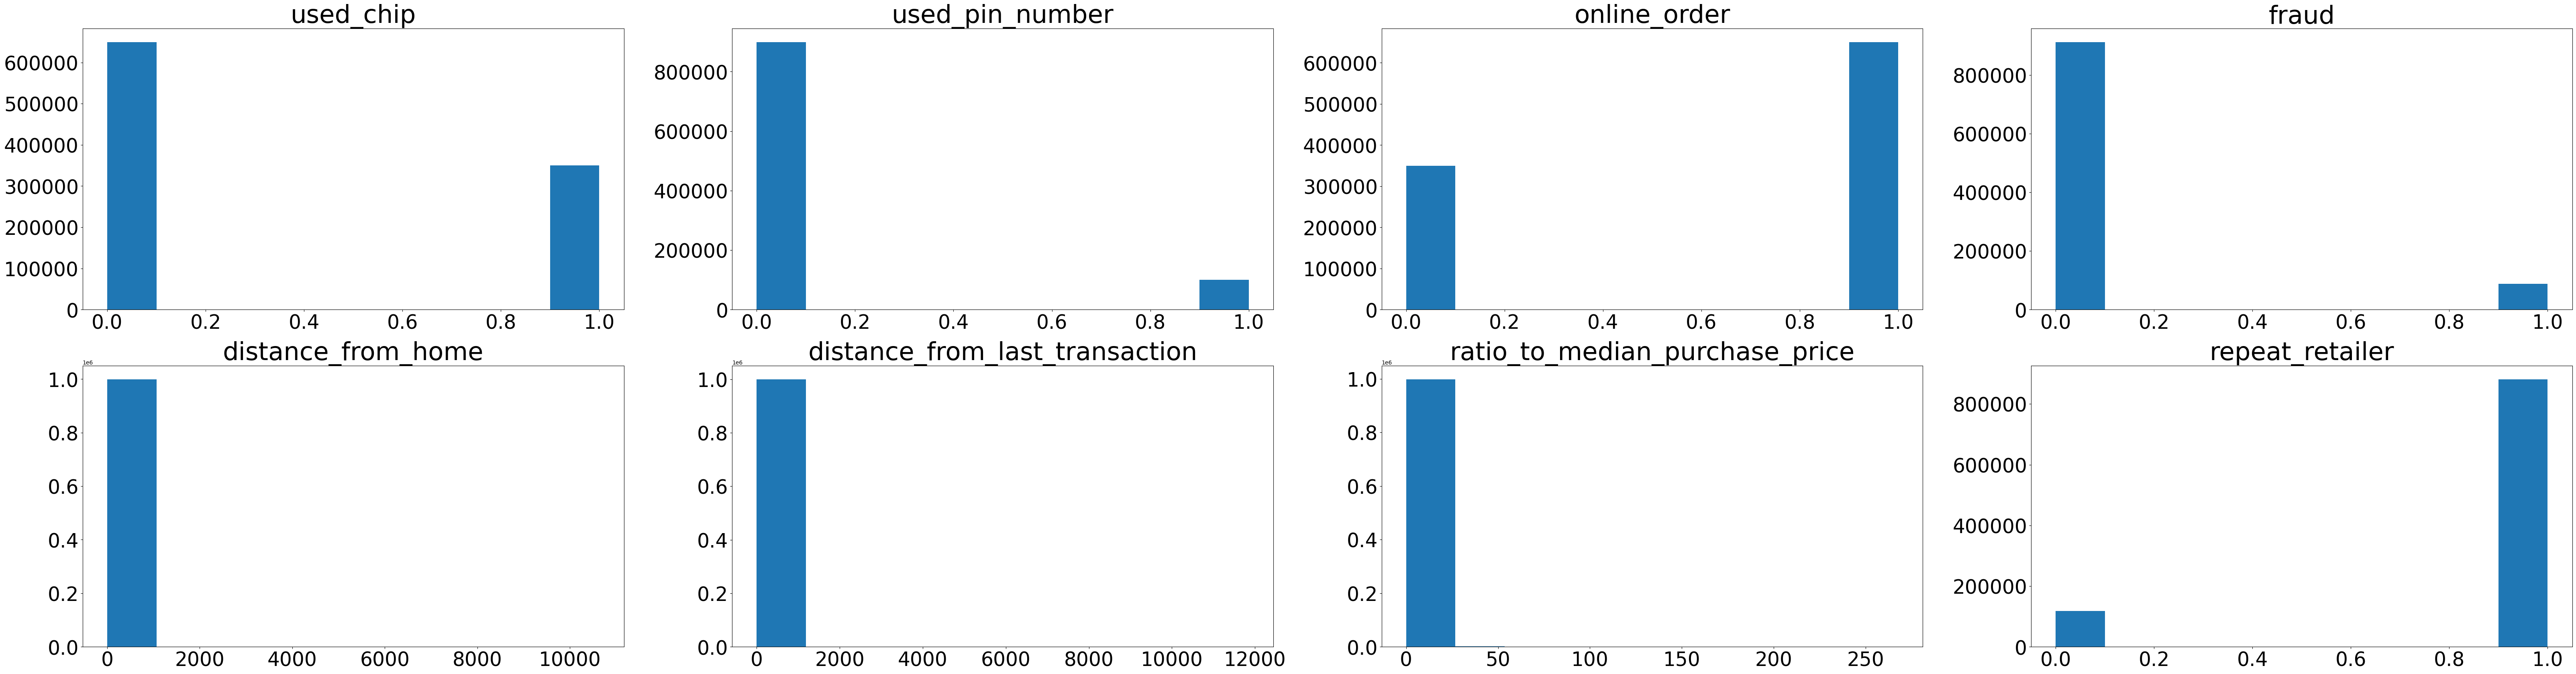

In [104]:
num_cols = len(df.columns)
num_rows = 2
fig, ax = plt.subplots(figsize=(num_cols*10, 20), nrows=num_rows, ncols=int(num_cols/num_rows))
for index, column_name in enumerate(df.columns):
    row = 0 if index+1 > num_cols/num_rows else 1
    col = index % int(num_cols/num_rows)
    ax[row][col].hist(df[column_name]);
    ax[row][col].set_title(column_name, fontsize=45)
    ax[row][col].tick_params(axis='x', labelsize=35)
    ax[row][col].tick_params(axis='y', labelsize=35)

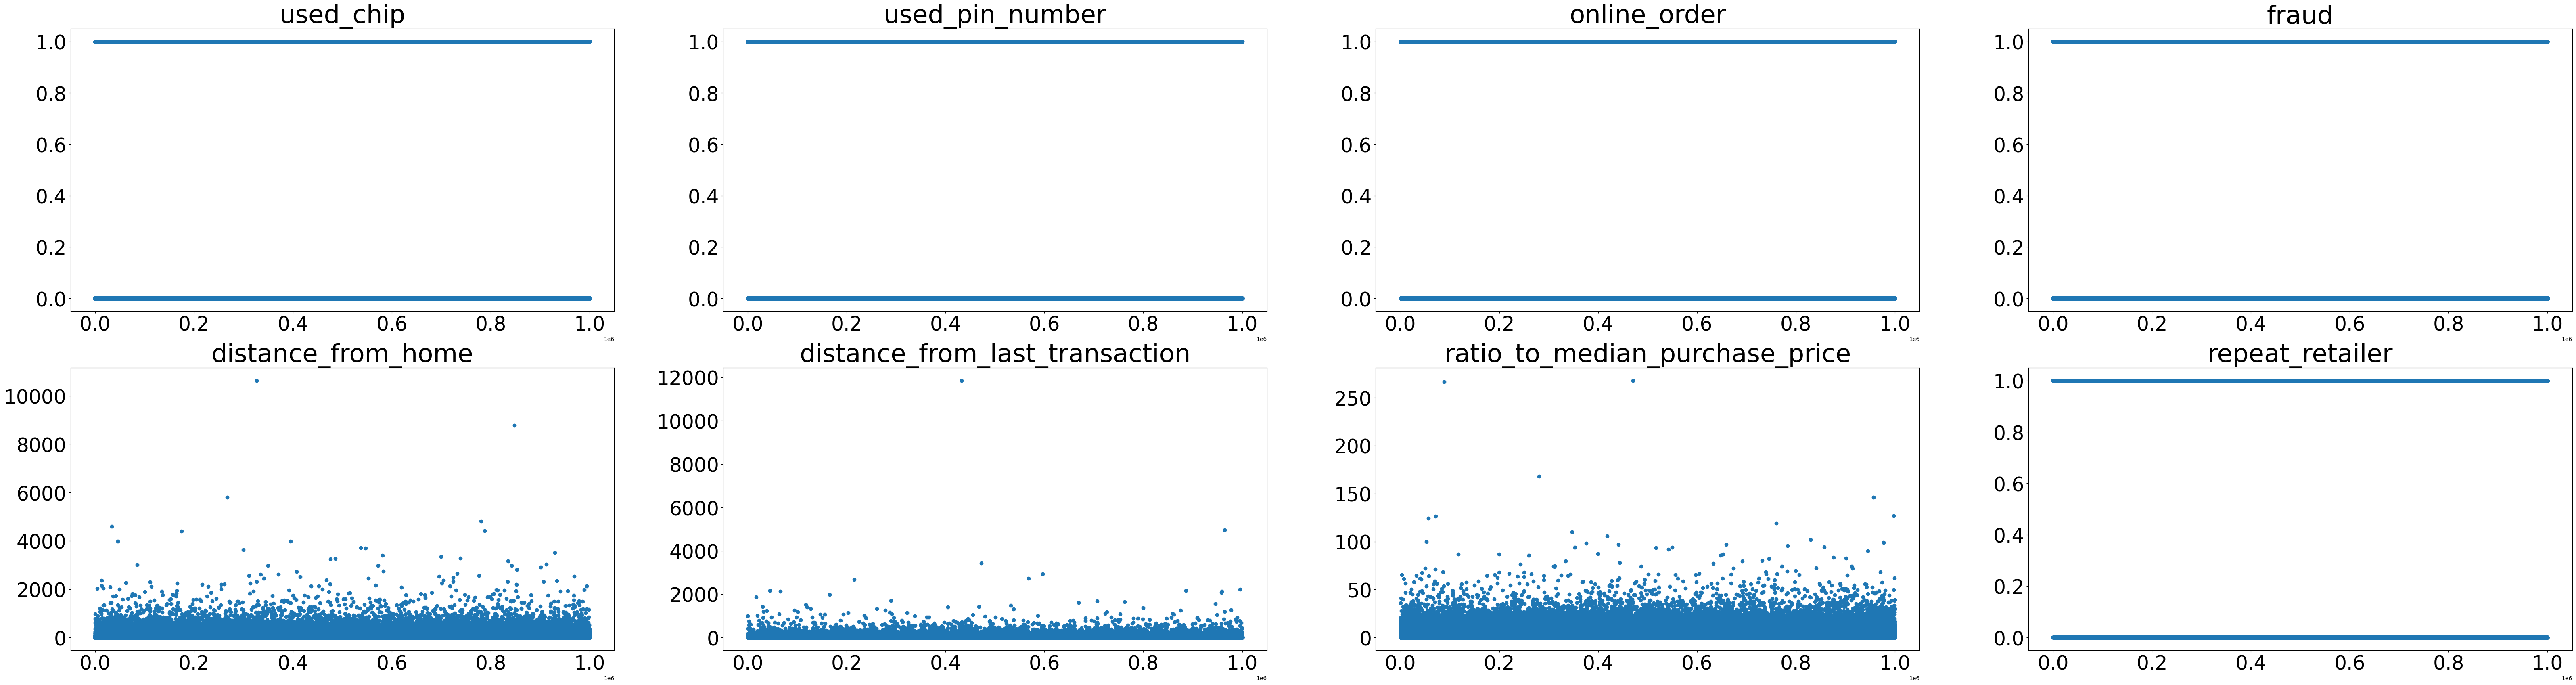

In [105]:
fig, ax = plt.subplots(figsize=(num_cols*10, 20), nrows=num_rows, ncols=int(num_cols/num_rows))
for index, column_name in enumerate(df.columns):
    row = 0 if index+1 > num_cols/num_rows else 1
    col = index % int(num_cols/num_rows)
    ax[row][col].scatter(df.index, df[column_name]);
    ax[row][col].set_title(column_name, fontsize=45)
    ax[row][col].tick_params(axis='x', labelsize=35)
    ax[row][col].tick_params(axis='y', labelsize=35)

### Dataset Clean-up

In [106]:
df.isnull().mean()

distance_from_home                0.0
distance_from_last_transaction    0.0
ratio_to_median_purchase_price    0.0
repeat_retailer                   0.0
used_chip                         0.0
used_pin_number                   0.0
online_order                      0.0
fraud                             0.0
dtype: float64

In [107]:
duplicates = df.duplicated()

In [108]:
df[duplicates].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              0 non-null      float64
 1   distance_from_last_transaction  0 non-null      float64
 2   ratio_to_median_purchase_price  0 non-null      float64
 3   repeat_retailer                 0 non-null      float64
 4   used_chip                       0 non-null      float64
 5   used_pin_number                 0 non-null      float64
 6   online_order                    0 non-null      float64
 7   fraud                           0 non-null      float64
dtypes: float64(8)
memory usage: 0.0 bytes


# Exploratory Data Analysis

### Comparing dataset values for fraudulent and non-fraudulent transactions

In [109]:
df[df['fraud'] == 1].describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,87403.000000,87403.000000,87403.000000,87403.000000,87403.000000,87403.000000,87403.000000,87403.0
mean,66.261876,12.712185,6.006323,0.880119,0.256399,0.003123,0.946318,1.0
std,134.391608,47.997697,5.564320,0.324825,0.436647,0.055801,0.225391,0.0
min,0.025847,0.000407,0.011966,0.000000,0.000000,0.000000,0.000000,1.0
25%,4.585729,0.328199,3.500270,1.000000,0.000000,0.000000,1.000000,1.0
50%,15.454219,1.157631,5.071294,1.000000,0.000000,0.000000,1.000000,1.0
75%,101.110104,4.598504,7.331222,1.000000,1.000000,0.000000,1.000000,1.0
max,10632.723672,2160.499922,266.689692,1.000000,1.000000,1.000000,1.000000,1.0


In [110]:
df[df['fraud'] == 0].describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,912597.000000,912597.000000,912597.000000,912597.000000,912597.000000,912597.000000,912597.000000,912597.0
mean,22.832976,4.301391,1.423642,0.881672,0.359402,0.109944,0.622225,0.0
std,52.828655,22.472359,1.946152,0.322997,0.479825,0.312821,0.484831,0.0
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.0
25%,3.828942,0.293859,0.449768,1.000000,0.000000,0.000000,0.000000,0.0
50%,9.673847,0.985074,0.913950,1.000000,0.000000,0.000000,1.000000,0.0
75%,24.158057,3.268578,1.788918,1.000000,1.000000,0.000000,1.000000,0.0
max,8777.136420,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,0.0


- higher rate of fraud in larger transactions

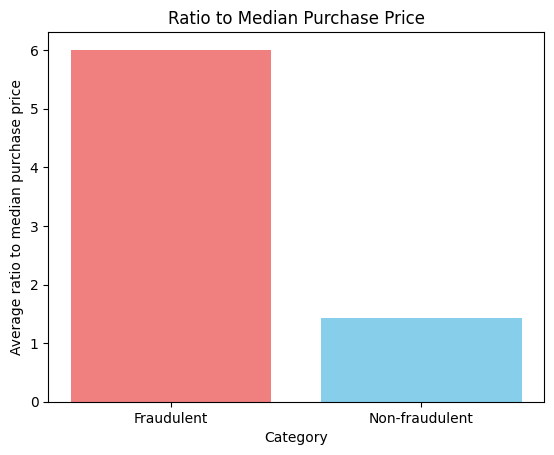

In [111]:
plt.bar(
    ['Fraudulent',  'Non-fraudulent'],
    [
        df[df['fraud'] == 1].describe()['ratio_to_median_purchase_price']['mean'],
        df[df['fraud'] == 0].describe()['ratio_to_median_purchase_price']['mean']
    ],
    color=['lightcoral', 'skyblue']
)
plt.title("Ratio to Median Purchase Price")
plt.xlabel("Category")
plt.ylabel("Average ratio to median purchase price");

### Checking features correlation with target

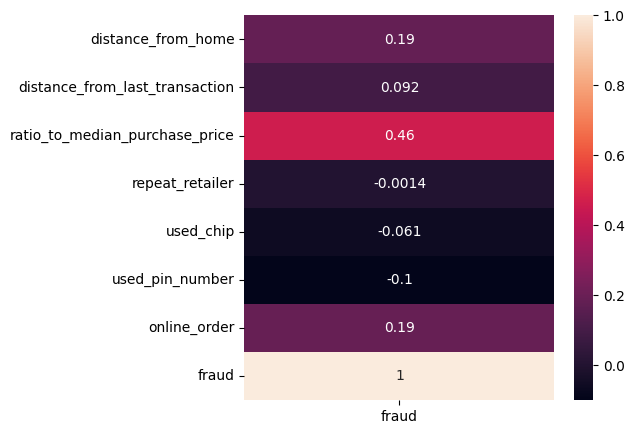

In [112]:
plt.figure(figsize=(5, 5))
sns.heatmap(pd.DataFrame(df.corr()['fraud']), annot=True);

### Comparing security of chip and pin transactions

In [113]:
df.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

In [114]:
df[['used_chip', 'used_pin_number']][df['fraud'] == 1].value_counts(normalize=True)

used_chip  used_pin_number
0.0        0.0                0.740581
1.0        0.0                0.256296
0.0        1.0                0.003020
1.0        1.0                0.000103
Name: proportion, dtype: float64

In [115]:
fraud_num = df['fraud'][df['fraud'] == 1].sum()
no_chip_no_pin_fraud_num = df[(df['used_chip'] == 0) & (df['used_pin_number'] == 0) & (df['fraud'] == 1)].shape[0]
only_chip_fraud_num = df[(df['used_chip'] == 1) & (df['used_pin_number'] == 0) & (df['fraud'] == 1)].shape[0]
only_pin_fraud_num = df[(df['used_chip'] == 0) & (df['used_pin_number'] == 1) & (df['fraud'] == 1)].shape[0]
chip_and_pin_fraud_num = df[(df['used_chip'] == 1) & (df['used_pin_number'] == 1) & (df['fraud'] == 1)].shape[0]

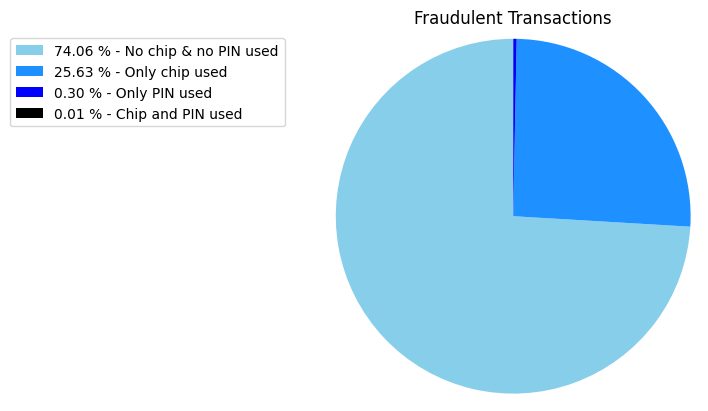

In [116]:
labels = [
    'No chip & no PIN used', 
    'Only chip used', 
    'Only PIN used', 
    'Chip and PIN used']
sizes = np.array([
    no_chip_no_pin_fraud_num, 
    only_chip_fraud_num, 
    only_pin_fraud_num, 
    chip_and_pin_fraud_num
])
colors = ['skyblue', 'dodgerblue', 'blue', 'black']
percent = 100.*sizes/sizes.sum()
labels = ['{1:2.2f} % - {0}'.format(i,j) for i,j in zip(labels, percent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.title("Fraudulent Transactions")
plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=10)
plt.show();

### Comparing fraudulent and non-fraudulent cases for online transactions

In [117]:
online_order_grp = df.groupby('online_order')

In [118]:
online_order_grp.fraud.value_counts()

online_order  fraud
0.0           0.0      344756
              1.0        4692
1.0           0.0      567841
              1.0       82711
Name: count, dtype: int64

In [119]:
online_order_grp.fraud.value_counts(normalize=True)

online_order  fraud
0.0           0.0      0.986573
              1.0      0.013427
1.0           0.0      0.872860
              1.0      0.127140
Name: proportion, dtype: float64

- the fraud percantage is significantly higher for online transactions (offline: 1.34%, online: 12.71%)

### Checking feature importance

In [120]:
X = df.drop(columns=['fraud'])
y = df['fraud']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_selector = RandomForestClassifier(random_state=42)
feature_selector.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [122]:
pd.Series(feature_selector.feature_importances_, index=X.columns).sort_values(ascending=False)

ratio_to_median_purchase_price    0.527171
online_order                      0.169382
distance_from_home                0.134910
used_pin_number                   0.063928
used_chip                         0.052078
distance_from_last_transaction    0.045711
repeat_retailer                   0.006820
dtype: float64

In [123]:
X_train.columns[feature_selector.feature_importances_.argsort()[::-1]]

Index(['ratio_to_median_purchase_price', 'online_order', 'distance_from_home',
       'used_pin_number', 'used_chip', 'distance_from_last_transaction',
       'repeat_retailer'],
      dtype='object')

- ratio_to_median_purchase_price, online_order, and distance_from_home are most correlated with the fraud based on RandomForestClassifier, which aligns with correlation values seen in the heatmap above

# Building And Evaluating Models

### Logistic Regression

- #### baseline (imbalanced dataset)

In [124]:
X = df.drop(columns=['fraud'])
y = df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [126]:
start_time = time.time()

In [127]:
lr_model = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    182557
         1.0       0.89      0.60      0.72     17443

    accuracy                           0.96    200000
   macro avg       0.93      0.80      0.85    200000
weighted avg       0.96      0.96      0.96    200000



In [128]:
f"Elapsed time: {round(time.time() - start_time, 2)} s"

'Elapsed time: 1.9 s'

---

- #### baseline (balanced dataset)

In [129]:
X = df.drop(columns=['fraud'])
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# undersampling the majority class with RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

# oversampling the minority class with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# scaling data
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [130]:
lr_model = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    182519
         1.0       0.58      0.95      0.72     17481

    accuracy                           0.93    200000
   macro avg       0.79      0.94      0.84    200000
weighted avg       0.96      0.93      0.94    200000



In [131]:
# balancing data manually
non_fraud_df = df[df['fraud'] == 0]
fraud_df = df[df['fraud'] == 1]
balanced_df_size = fraud_df.shape[0]*2
non_fraud_category_size = 0.5
fraud_category_size = round(1 - non_fraud_category_size, 2)
non_fraud_sampled_df = non_fraud_df.sample(int(balanced_df_size*non_fraud_category_size), random_state=42)
fraud_sampled_df = fraud_df.sample(int(balanced_df_size*fraud_category_size), random_state=42)
df_balanced = pd.concat([non_fraud_sampled_df, fraud_sampled_df])
df_balanced = df_balanced.sample(balanced_df_size, random_state=42)  # shuffles df

X_balanced = df_balanced.drop(columns=['fraud'])
y_balanced = df_balanced['fraud']

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_balanced_scaled = scaler.transform(X_test_balanced)

In [132]:
start_time = time.time()

In [133]:
lr_model = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
lr_model.fit(X_train_balanced_scaled, y_train_balanced)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [134]:
y_pred = lr_model.predict(X_test_balanced_scaled)
print(classification_report(y_test_balanced, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94     17481
         1.0       0.93      0.95      0.94     17481

    accuracy                           0.94     34962
   macro avg       0.94      0.94      0.94     34962
weighted avg       0.94      0.94      0.94     34962



In [135]:
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    182519
         1.0       0.57      0.95      0.71     17481

    accuracy                           0.93    200000
   macro avg       0.78      0.94      0.84    200000
weighted avg       0.96      0.93      0.94    200000



In [136]:
f"Elapsed time: {round(time.time() - start_time, 2)} s"

'Elapsed time: 0.86 s'

---

- #### hyperparameter tuning (grid search)

In [137]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}],
    'tol': [1e-4, 1e-3, 1e-2],
    'fit_intercept': [True, False],
}

In [138]:
start_time = time.time()

In [139]:
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

model = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

optimizer = GridSearchCV(model, param_grid, cv=3, scoring='recall')
optimizer.fit(X_train_balanced_scaled, y_train_balanced)
print(optimizer.best_score_)
print(optimizer.best_params_)
best_model = optimizer.best_estimator_

warnings.resetwarnings()

0.9944938570219533
{'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'fit_intercept': True, 'penalty': 'l2', 'tol': 0.0001}


In [140]:
y_pred = best_model.predict(X_test_balanced_scaled)
print(classification_report(y_test_balanced, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92     17481
         1.0       0.87      0.99      0.93     17481

    accuracy                           0.93     34962
   macro avg       0.93      0.93      0.93     34962
weighted avg       0.93      0.93      0.93     34962



In [141]:
f"Elapsed time: {round(time.time() - start_time, 2)} s"

'Elapsed time: 236.68 s'

In [142]:
# start_time = time.time()

In [143]:
# warnings.filterwarnings("ignore", category=FitFailedWarning)
# warnings.filterwarnings("ignore", category=UserWarning)

# model = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

# optimizer = GridSearchCV(model, param_grid, cv=3, scoring='f1')
# optimizer.fit(X_train_balanced_scaled, y_train_balanced)
# print(optimizer.best_score_)
# print(optimizer.best_params_)
# best_model = optimizer.best_estimator_

# warnings.resetwarnings()

In [144]:
# y_pred = best_model.predict(X_test_balanced_scaled)
# print(classification_report(y_test_balanced, y_pred))

In [145]:
# f"Elapsed time: {round(time.time() - start_time, 2)} s"

### Support Vector Machines

- #### baseline (imbalanced dataset)

In [146]:
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(
    X, y, train_size=30000, test_size=30000, stratify=y, random_state=42
)

In [147]:
scaler = StandardScaler()
X_train_sampled_scaled = scaler.fit_transform(X_train_sampled)
X_test_sampled_scaled = scaler.transform(X_test_sampled)

In [148]:
start_time = time.time()

In [149]:
svc_model = SVC(kernel='linear', probability=True, random_state=42)
cal_svc_model = CalibratedClassifierCV(svc_model)
cal_svc_model.fit(X_train_sampled_scaled, y_train_sampled)
y_pred = cal_svc_model.predict(X_test_sampled_scaled)
print(classification_report(y_test_sampled, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     27378
         1.0       0.90      0.57      0.69      2622

    accuracy                           0.96     30000
   macro avg       0.93      0.78      0.84     30000
weighted avg       0.95      0.96      0.95     30000



In [150]:
f"Elapsed time: {round(time.time() - start_time, 2)} s"

'Elapsed time: 48.94 s'

---

- #### baseline (balanced dataset)

In [151]:
# undersampling the majority class with RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_sampled, y_train_sampled = rus.fit_resample(X_train_sampled, y_train_sampled)

# oversampling the minority class with SMOTE
smote = SMOTE(random_state=42)
X_train_sampled, y_train_sampled = smote.fit_resample(X_train_sampled, y_train_sampled)

# scaling data
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sampled = scaler.fit_transform(X_train_sampled)
X_test_sampled = scaler.transform(X_test_sampled)

In [152]:
svc_model = SVC(kernel='linear', probability=True, random_state=42)
cal_svc_model = CalibratedClassifierCV(svc_model)
cal_svc_model.fit(X_train_sampled, y_train_sampled)
y_pred = cal_svc_model.predict(X_test_sampled)
print(classification_report(y_test_sampled, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     27378
         1.0       0.57      0.97      0.72      2622

    accuracy                           0.93     30000
   macro avg       0.78      0.95      0.84     30000
weighted avg       0.96      0.93      0.94     30000



In [153]:
non_fraud_df = df[df['fraud'] == 0]
fraud_df = df[df['fraud'] == 1]
balanced_df_size = 30000
non_fraud_category_size = 0.5
fraud_category_size = round(1 - non_fraud_category_size, 2)
non_fraud_sampled_df = non_fraud_df.sample(int(balanced_df_size*non_fraud_category_size), random_state=42)
fraud_sampled_df = fraud_df.sample(int(balanced_df_size*fraud_category_size), random_state=42)
df_balanced = pd.concat([non_fraud_sampled_df, fraud_sampled_df])
df_balanced = df_balanced.sample(balanced_df_size, random_state=42)  # shuffles df

X_balanced = df_balanced.drop(columns=['fraud'])
y_balanced = df_balanced['fraud']

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_balanced_scaled = scaler.transform(X_test_balanced)

In [154]:
start_time = time.time()

In [155]:
print(
    f"""
    balanced_df_size: {balanced_df_size} 
    non_fraud_category_size: {non_fraud_category_size}
    fraud_category_size: {fraud_category_size}
    """
)


    balanced_df_size: 30000 
    non_fraud_category_size: 0.5
    fraud_category_size: 0.5
    


In [156]:
svc_model = SVC(kernel='linear', probability=True, random_state=42)
cal_svc_model = CalibratedClassifierCV(svc_model)
cal_svc_model.fit(X_train_balanced_scaled, y_train_balanced)
y_pred = cal_svc_model.predict(X_test_balanced_scaled)
print(classification_report(y_test_balanced, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      3000
         1.0       0.94      0.96      0.95      3000

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



In [157]:
y_pred = cal_svc_model.predict(X_test_sampled)
print(classification_report(y_test_sampled, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     27378
         1.0       0.57      0.96      0.71      2622

    accuracy                           0.93     30000
   macro avg       0.78      0.94      0.84     30000
weighted avg       0.96      0.93      0.94     30000



In [158]:
f"Elapsed time: {round(time.time() - start_time, 2)} s"

'Elapsed time: 48.18 s'

---

- #### hyperparameter tuning (grid search)

In [159]:
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(
    X, y, train_size=10000, test_size=10000, stratify=y, random_state=42
)

# undersampling the majority class with RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_sampled, y_train_sampled = rus.fit_resample(X_train_sampled, y_train_sampled)

# oversampling the minority class with SMOTE
smote = SMOTE(random_state=42)
X_train_sampled, y_train_sampled = smote.fit_resample(X_train_sampled, y_train_sampled)

# scaling data
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sampled = scaler.fit_transform(X_train_sampled)
X_test_sampled = scaler.transform(X_test_sampled)

In [160]:
param_grid = {
    'base_estimator__C': [0.1, 1, 10],
    'base_estimator__kernel': ['linear', 'rbf'],
    'base_estimator__gamma': ['scale', 'auto', 0.1],
    'base_estimator__degree': [2, 3, 4],
    'base_estimator__class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]
}

In [161]:
start_time = time.time()

In [162]:
warnings.filterwarnings("ignore", category=FutureWarning)
# /home/bugi/.pyenv/versions/data-science-pro/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 
# 'base_estimator' of CalibratedClassifierCV is deprecated in favor of 'estimator'. See CalibratedClassifierCV's docstring for more details.
  # estimator = estimator.set_params(**clone(parameters, safe=False))

svc_model = SVC()
cal_svc_model = CalibratedClassifierCV(svc_model)

optimizer = GridSearchCV(
    cal_svc_model,
    param_grid,
    cv=3,
    scoring='recall'
)
optimizer.fit(X_train_sampled, y_train_sampled)

warnings.resetwarnings()

In [163]:
print(optimizer.best_params_)
print(optimizer.best_score_)
best_model = optimizer.best_estimator_

{'base_estimator__C': 10, 'base_estimator__class_weight': {0: 1, 1: 3}, 'base_estimator__degree': 2, 'base_estimator__gamma': 'scale', 'base_estimator__kernel': 'rbf'}
0.9954249752927052


In [164]:
y_pred = best_model.predict(X_test_sampled)
print(classification_report(y_test_sampled, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      9126
         1.0       0.82      0.98      0.90       874

    accuracy                           0.98     10000
   macro avg       0.91      0.98      0.94     10000
weighted avg       0.98      0.98      0.98     10000



In [165]:
f"Elapsed time: {round(time.time() - start_time, 2)} s"

'Elapsed time: 88.92 s'

### DecisionTreeClassifier

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [191]:
start_time = time.time()

In [192]:
dtc_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dtc_model.fit(X_train, y_train)
y_pred = dtc_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       0.99      1.00      0.99     17481

    accuracy                           1.00    200000
   macro avg       0.99      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



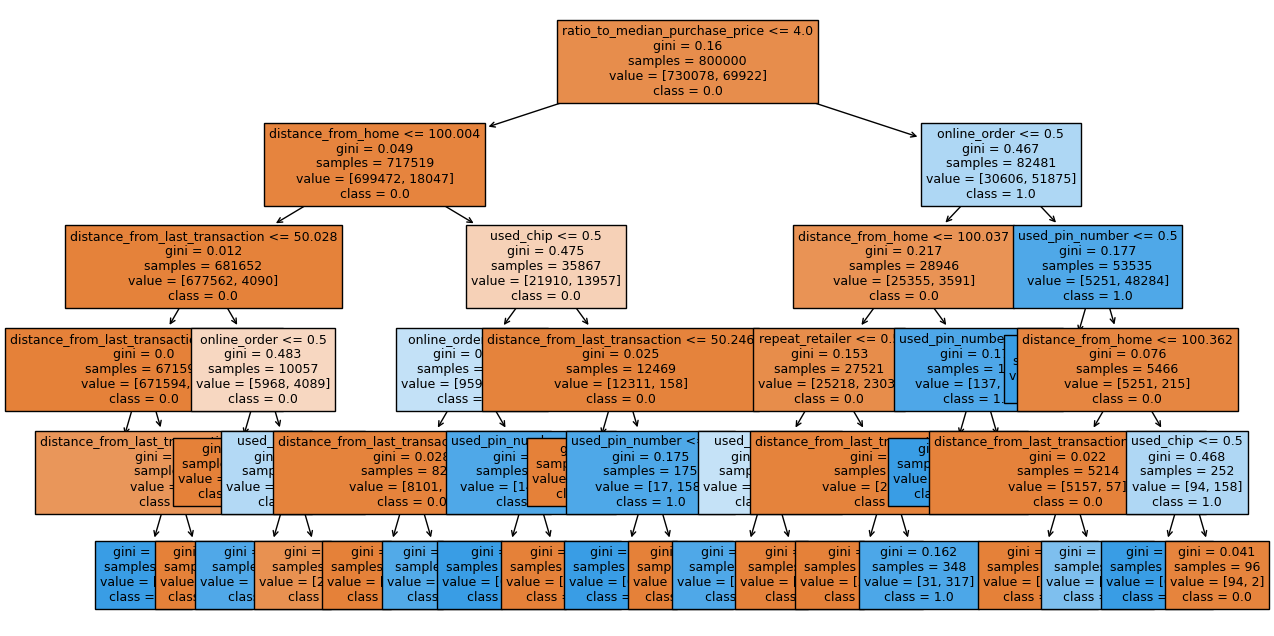

In [193]:
plt.figure(figsize=(15, 8))
plot_tree(
    dtc_model, 
    filled=True, 
    feature_names=list(dtc_model.feature_names_in_), 
    class_names=list(dtc_model.classes_.astype('str'))
)
for text in plt.gca().get_children():
    if isinstance(text, plt.Text):
        text.set_fontsize(9)
plt.show();

In [194]:
f"Elapsed time: {round(time.time() - start_time, 2)} s"

'Elapsed time: 2.41 s'

### RandomForestClassifier

In [195]:
start_time = time.time()

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [197]:
rfc_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc_model.fit(X_train, y_train)
y_pred = rfc_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       1.00      1.00      1.00     17481

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [198]:
f"Elapsed time: {round(time.time() - start_time, 2)} s"

'Elapsed time: 8.97 s'

- trained with X_train.values to be saved and used in a containerized fastapi application

In [199]:
rfc_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc_model.fit(X_train.values, y_train.values)
y_pred = rfc_model.predict(X_test.values)
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182519
         1.0       1.00      1.00      1.00     17481

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [200]:
filepath = os.path.join(os.path.pardir, 'models', 'rf_clf.pkl')
with open(filepath, 'wb') as file:
    pickle.dump(rfc_model, file)